# Airline Loyalty Program Analysis with Annotated Decision Tree and Clustering

In [1]:
# Upload CSV files manually in Colab
from google.colab import files
uploaded = files.upload()

Saving Calendar.csv to Calendar.csv
Saving Customer Flight Activity.csv to Customer Flight Activity.csv
Saving Customer Loyalty History.csv to Customer Loyalty History.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, confusion_matrix)
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, f_oneway
import os
%matplotlib inline

In [3]:
# Load uploaded files
calendar_df = pd.read_csv("Calendar.csv")
flight_df = pd.read_csv("Customer Flight Activity.csv")
loyalty_df = pd.read_csv("Customer Loyalty History.csv")

In [4]:
# Data cleaning and merging
loyalty_df.dropna(subset=['Salary'], inplace=True)
loyalty_df = loyalty_df[loyalty_df['Salary'] > 0]
df = pd.merge(flight_df, loyalty_df, on="Loyalty Number")
df = df[(df['Points Accumulated'] >= 0) & (df['Total Flights'] >= 0)]
df.drop_duplicates(inplace=True)
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')
df.dropna(subset=['Salary', 'Distance'], inplace=True)

In [5]:
# Feature engineering: Create engagement score and high engagement flag
df['Engagement_Score'] = df['Points Accumulated'] + (df['Total Flights'] * 100)
threshold = df['Engagement_Score'].quantile(0.7)
df['High_Engagement'] = (df['Engagement_Score'] >= threshold).astype(int)

<ipython-input-6-2816788506>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=col, y='Engagement_Score', estimator=np.mean, errorbar=None, order=order, palette="viridis")


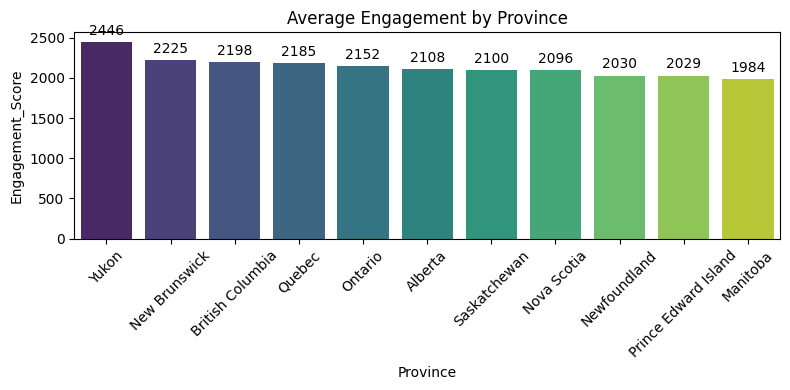

<ipython-input-6-2816788506>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=col, y='Engagement_Score', estimator=np.mean, errorbar=None, order=order, palette="viridis")


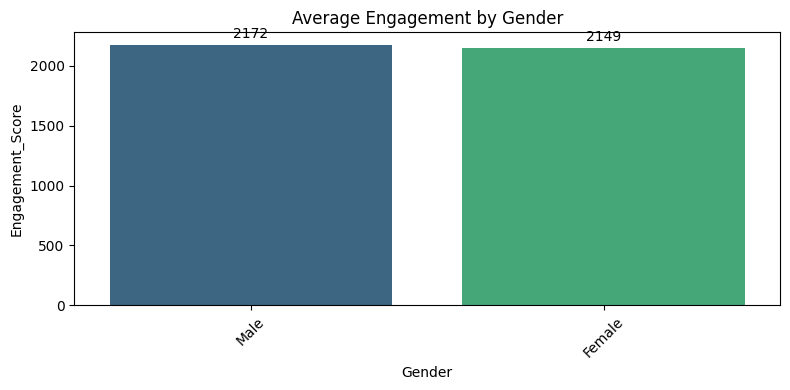

<ipython-input-6-2816788506>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=col, y='Engagement_Score', estimator=np.mean, errorbar=None, order=order, palette="viridis")


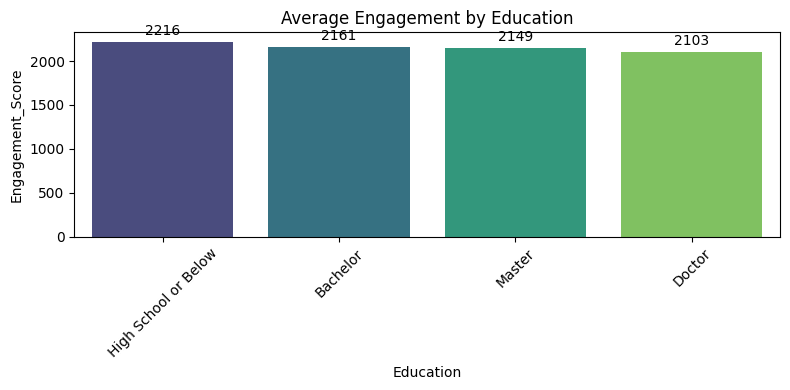

In [6]:
# EDA: Bar charts with value labels for demographic features
for col in ['Province', 'Gender', 'Education']:
    plt.figure(figsize=(8, 4))
    order = df.groupby(col)['Engagement_Score'].mean().sort_values(ascending=False).index
    ax = sns.barplot(data=df, x=col, y='Engagement_Score', estimator=np.mean, errorbar=None, order=order, palette="viridis")
    plt.title(f'Average Engagement by {col}')
    plt.xticks(rotation=45)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", label_type="edge", padding=3)
    plt.tight_layout()
    plt.show()

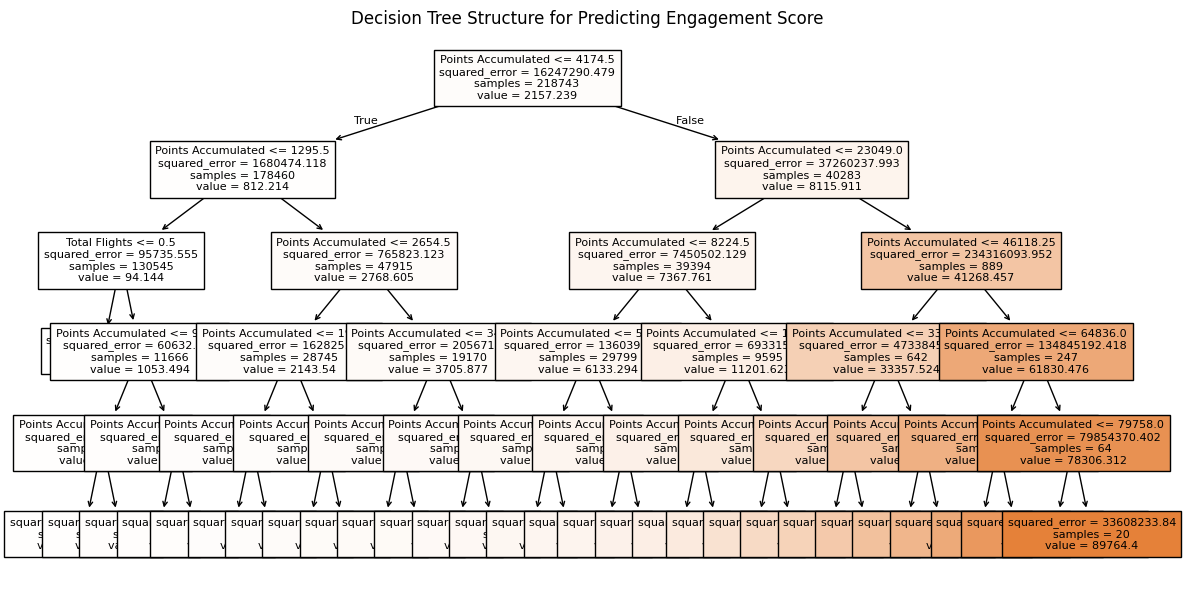

In [7]:
# --- DECISION TREE REGRESSOR SECTION ---
# We use DecisionTreeRegressor because it does not assume linearity or constant variance of residuals.
# It handles complex relationships and interactions between features.

# Step 1: Define predictors and target
features = ['Salary', 'Total Flights', 'Points Accumulated']
X = df[features].fillna(0)
y = df['Engagement_Score']

# Step 2: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Step 3: Train the model
dtr = DecisionTreeRegressor(max_depth=5, random_state=42)
dtr.fit(X_train, y_train)

# Step 4: Visualize the decision tree to understand how the model splits data
plt.figure(figsize=(12, 6))
plot_tree(dtr, feature_names=features, filled=True, fontsize=8)
plt.title("Decision Tree Structure for Predicting Engagement Score")
plt.tight_layout()
plt.show()

# Final Outcome: The tree structure shows segmentation rules based on salary, total flights, and points accumulated.
# Each leaf node shows the average predicted engagement score for that group.


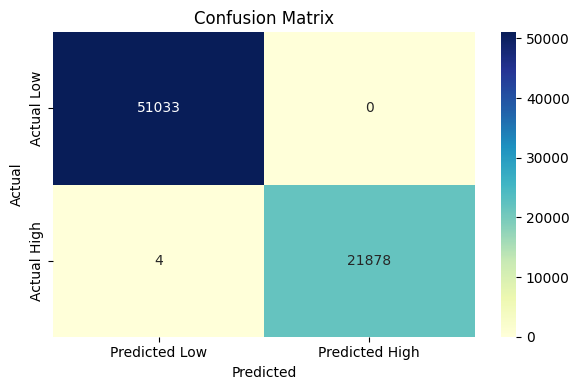

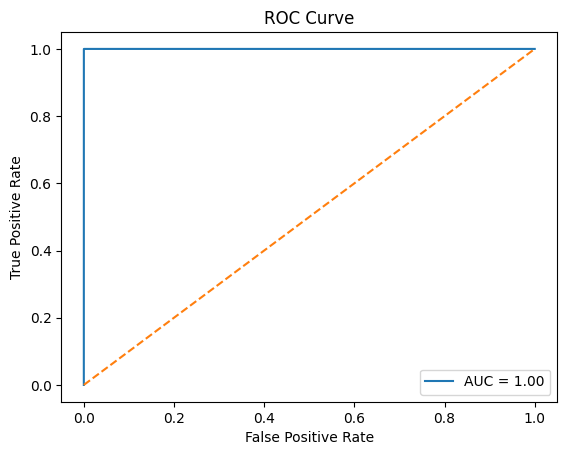

Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9998
AUC: 1.0000


In [8]:
# Logistic Regression Classification
y_class = df['High_Engagement']
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X, y_class, random_state=42)
logreg = LogisticRegression(max_iter=1000).fit(X_train_cl, y_train_cl)
y_pred_cl = logreg.predict(X_test_cl)
y_prob_cl = logreg.predict_proba(X_test_cl)[:, 1]

# Confusion matrix (no labels inside cells)
cm = confusion_matrix(y_test_cl, y_pred_cl)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Predicted Low", "Predicted High"], yticklabels=["Actual Low", "Actual High"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_cl, y_prob_cl)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_cl, y_prob_cl):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Print metrics
accuracy = accuracy_score(y_test_cl, y_pred_cl)
precision = precision_score(y_test_cl, y_pred_cl)
recall = recall_score(y_test_cl, y_pred_cl)
auc = roc_auc_score(y_test_cl, y_prob_cl)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

In [9]:
# Statistical Tests
anova_edu = f_oneway(*[group["Engagement_Score"].values for name, group in df.groupby("Education")])
anova_inc = f_oneway(*[group["Engagement_Score"].values for name, group in df.groupby(pd.qcut(df["Salary"], q=4))])
t_test_gender = ttest_ind(df[df['Gender'] == 'Male']['Engagement_Score'],
                          df[df['Gender'] == 'Female']['Engagement_Score'],
                          nan_policy='omit')

print(f"ANOVA (Education) p-value: {anova_edu.pvalue}")
print(f"ANOVA (Income Quartile) p-value: {anova_inc.pvalue}")
print(f"T-Test (Gender) p-value: {t_test_gender.pvalue}")

ANOVA (Education) p-value: 0.06966255395959592
ANOVA (Income Quartile) p-value: 1.5640908507586195e-15
T-Test (Gender) p-value: 0.1227884076568816


<ipython-input-9-2522233976>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anova_inc = f_oneway(*[group["Engagement_Score"].values for name, group in df.groupby(pd.qcut(df["Salary"], q=4))])


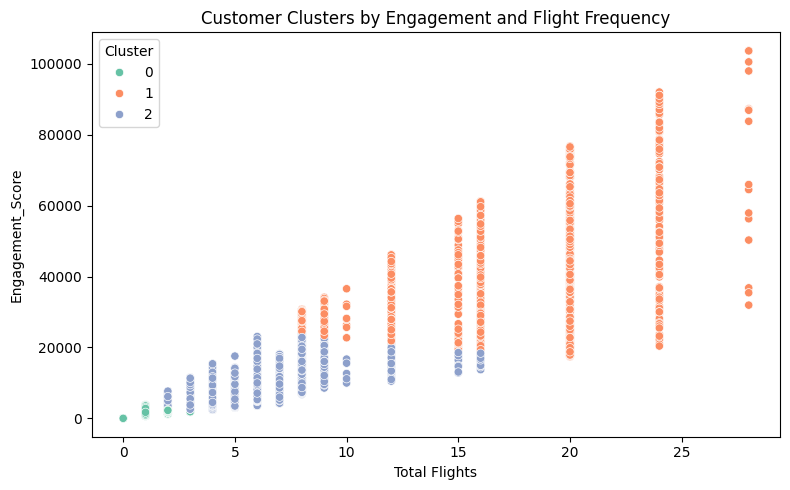

In [10]:
# --- K-MEANS CLUSTERING SECTION ---
# We perform clustering to group customers with similar flight and engagement patterns.

# Step 1: Standardize data
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[['Salary', 'Total Flights', 'Points Accumulated', 'Engagement_Score']])

# Step 2: Run KMeans clustering
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=300, random_state=42).fit(X_cluster)
df['Cluster'] = kmeans.labels_

# Step 3: Visualize clusters
# Each color in the chart represents a customer segment with similar engagement patterns.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Total Flights', y='Engagement_Score', hue='Cluster', palette='Set2')
plt.title("Customer Clusters by Engagement and Flight Frequency")
plt.tight_layout()
plt.show()

In [ ]:

# Calculate engagement score: Points Accumulated + (Total Flights * 100)
flight_df["Engagement Score"] = flight_df["Points Accumulated"] + (flight_df["Total Flights"] * 100)

# Compute correlation between Total Flights and Engagement Score
correlation_matrix = flight_df[["Total Flights", "Engagement Score"]].corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix: Total Flights vs Engagement Score")
plt.tight_layout()
plt.show()
